In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
archs = np.array([[3,-1],
                  [1.5,-2],
                  [0.3,1],
                  [2.4,2]])

In [16]:
X,Y = archs.T

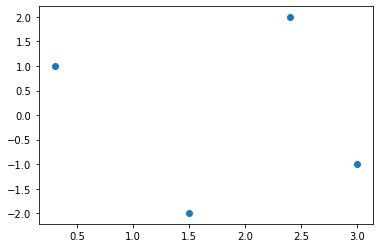

In [17]:
plt.scatter(X,Y)

In [53]:
def generate_data (archs, n_points, noise=0.1):
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    return data

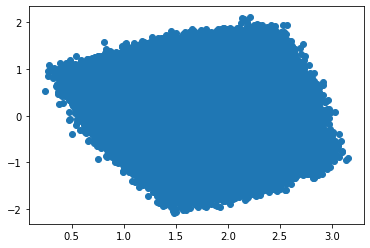

In [64]:
data = generate_data (archs,1000000)
dataX,dataY = data.T
plt.scatter(dataX,dataY)

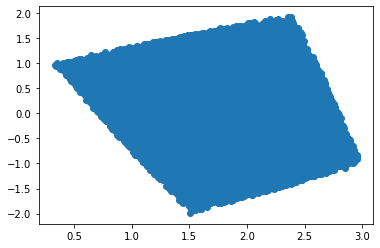

In [65]:
data = generate_data (archs,1000000,noise=0)
dataX,dataY = data.T
plt.scatter(dataX,dataY)